In [1]:
import os
import sys
homedir = os.getenv("USERPROFILE") if sys.platform=='win32' else os.getenv("HOME")

In [13]:
import glob
import os.path as op

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

factory_dir = op.join(homedir, "repos", "hybridfactory")
if not factory_dir in sys.path:
    sys.path.insert(0, factory_dir)

import factory.generate.generators
import factory.io.phy
import factory.io.raw
#import factory.probes.eMouse as probe
import factory.probes.npix3a as probe

In [3]:
%matplotlib notebook

In [4]:
def mat_svd(X):
    m, n = X.shape
        
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    U = np.matrix(U)
    S = np.matrix(np.diag(S))
    Vt = np.matrix(Vt)
    
    return U, S, Vt

def pca_whiten(X):
    m, n = X.shape
    if m > n:
        raise ValueError("rank incompetence")
        
    _, _, Vt = mat_svd(X)
    return np.sqrt(m)*Vt

def zca_whiten(X):
    m, n = X.shape
    if m > n:
        raise ValueError("rank incompetence")
        
    U, _, Vt = mat_svd(X)
    return np.sqrt(m) * U * Vt

def find_left_right(window, center=None):
    assert window.ndim == 1
    
    m = window.size//2
    rad = window.size//8
    
    if center is None:  # assume window is "centered" at event
        nbd = window[m-rad:m+rad]
        center = np.abs(nbd).argmax() + m - rad
        is_local_min = nbd[rad] == nbd.min()
        center = center 
    else:
        nbd = window[center-rad:center+rad]
        is_local_min = nbd[rad] == nbd.min()

    wdiff = np.diff(window)
    scale_factor = np.abs(wdiff)
    scale_factor[scale_factor == 0] = 1
    abswdiff = wdiff / scale_factor
    
    wdiff2 = np.diff(wdiff)
    scale_factor2 = np.abs(wdiff2)
    scale_factor2[scale_factor2 == 0] = 1
    abswdiff2 = wdiff2 / scale_factor2

    turning_points = np.union1d(np.where(np.array([abswdiff[i] != abswdiff[i+1] for i in range(abswdiff.size - 1)]))[0] + 1,
                                np.where(np.array([abswdiff2[i] != abswdiff2[i+1] for i in range(abswdiff2.size - 1)]))[0] + 2)
    #turning_points = np.where(np.array([abswdiff[i] != abswdiff[i+1] for i in range(abswdiff.size - 1)]))[0] + 1
    tp_center = np.abs(center-turning_points).argmin()
    #assert center == turning_points[tp_center]
    
    if tp_center < 2 or tp_center > turning_points.size - 2:
        if is_local_min:  # all differences are negative until center, then positive        
            # find the last difference before the center that is positive
            wleft = center - np.where(wdiff[:center-1][::-1] > 0)[0][0] # this is disgusting, numpy
            # find the first difference after the center that is negative
            wright = center + np.where(wdiff[center+1:] < 0)[0][0]
        else:
            # find the last difference before the center that is negative
            wleft = center - np.where(wdiff[:center-1][::-1] < 0)[0][0]
            # find the first difference after the center that is positive
            wright = center + np.where(wdiff[center+1:] > 0)[0][0]
    else:
        wleft = turning_points[tp_center-2] + (center - turning_points[tp_center-2])//2
        wright = turning_points[tp_center+2] + (turning_points[tp_center+2] - center)//2
        
    return wleft, wright

In [5]:
# eMouse = op.join(homedir, "Documents", "Data", "eMouse")

# source = factory.io.raw.open_raw(op.join(eMouse, "sim_binary.dat"), data_type=np.int16, num_channels=34)
# event_times = factory.io.phy.load_event_times(eMouse)
# event_clusters = factory.io.phy.load_event_clusters(eMouse)
# event_templates = factory.io.phy.load_event_templates(eMouse)
# templates = factory.io.phy.load_templates(eMouse)

# mask = (event_times<source.shape[1]-40)&(event_clusters==27)

# unit_times = event_times[mask]
# windows = factory.io.raw.unit_windows(source, event_times[mask],
#                                       samples_before=40, samples_after=41,
#                                       car_channels=np.where(probe.connected)[0])
# unit_channels = factory.generate.generators.threshold_events(windows, -30)

In [31]:
cortex = r"F:/CortexLab/singlePhase3/data/"
source = factory.io.raw.open_raw(op.join(cortex, "Hopkins_20160722_g0_t0.imec.ap_CAR.bin"),
                                 data_type=np.int16, num_channels=probe.NCHANS)
event_times = factory.io.phy.load_event_times(cortex)
event_clusters = factory.io.phy.load_event_clusters(cortex)
event_templates = factory.io.phy.load_event_templates(cortex)
templates = factory.io.phy.load_templates(cortex)

mask = event_clusters==3

unit_times = event_times[mask]
windows = factory.io.raw.unit_windows(source, event_times[mask],
                                      samples_before=40, samples_after=41,
                                      car_channels=np.where(probe.connected)[0])
unit_channels = factory.generate.generators.threshold_events(windows, -30)

1224


<IPython.core.display.Javascript object>


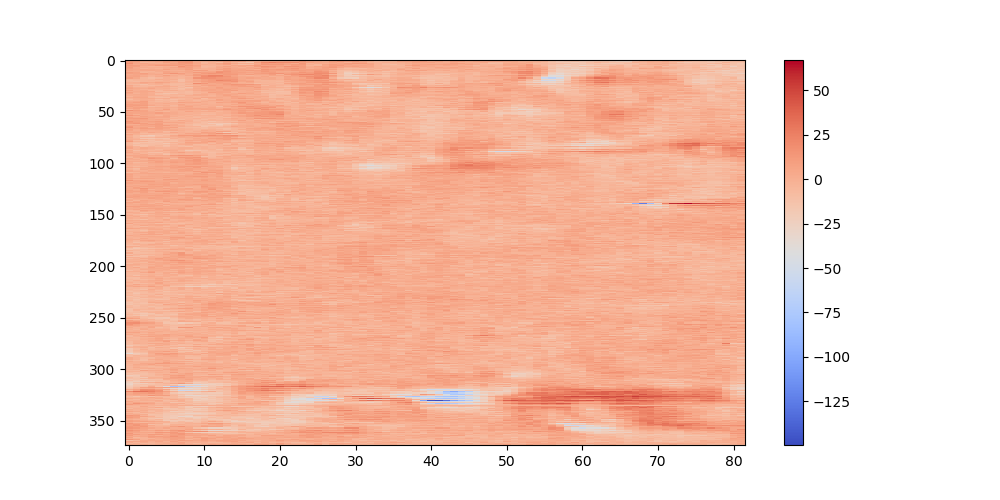

In [32]:
#np.random.seed(10191)
k = np.random.choice(windows.shape[2])
print(k)
#k = 5507

template = templates[event_clusters[mask][k]].T

X = windows[:, :, k]
m, n = X.shape

plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
plt.imshow(X[probe.channel_map[probe.connected]], "coolwarm", aspect="auto")
plt.colorbar()

event_center = unit_times[k]
event_samples = np.arange(event_center - 40,
                          event_center + 42, dtype=event_center.dtype)
event_window = factory.io.raw.read_roi(source, unit_channels, event_samples)
center_channel = event_window[:,40].argmin()

<IPython.core.display.Javascript object>


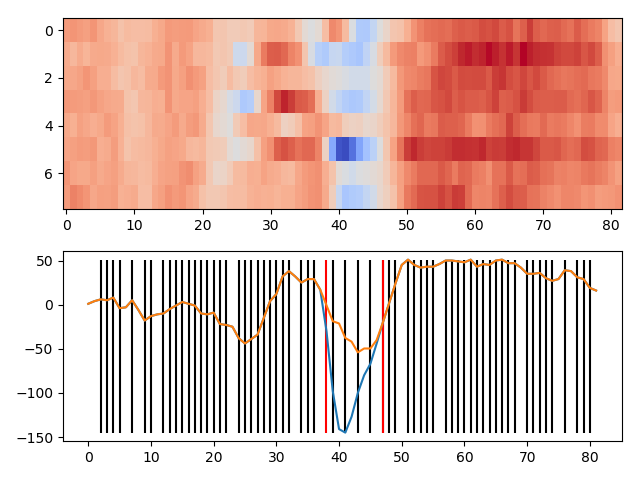

In [33]:
window = event_window[center_channel]
wl, wr = find_left_right(window)

wdiff = np.diff(window)
scale_factor = np.abs(wdiff)
scale_factor[scale_factor == 0] = 1
abswdiff = wdiff / scale_factor

wdiff2 = np.diff(wdiff)
scale_factor2 = np.abs(wdiff2)
scale_factor2[scale_factor2 == 0] = 1
abswdiff2 = wdiff2 / scale_factor2

turning_points = np.union1d(np.where(np.array([abswdiff[i] != abswdiff[i+1] for i in range(abswdiff.size - 1)]))[0] + 1,
                            np.where(np.array([abswdiff2[i] != abswdiff2[i+1] for i in range(abswdiff2.size - 1)]))[0] + 2)
#turning_points = np.where(np.array([abswdiff[i] != abswdiff[i+1] for i in range(abswdiff.size - 1)]))[0] + 1

exes = np.hstack((np.arange(wl), np.arange(wr, window.size)))
whys = window[exes]
f = scipy.interpolate.interp1d(exes, whys, "cubic")

notaspike = f(np.arange(window.size))
notaspike[wl:wr] += 3*np.random.randn(wr-wl)

plt.figure()

plt.subplot(2,1,1)
plt.imshow(event_window, "coolwarm", aspect="auto")

plt.subplot(2,1,2)
plt.plot(window)
plt.plot(notaspike)
plt.vlines(turning_points, ymin=window.min(), ymax=window.max(), colors='k')
plt.vlines((wl, wr), ymin=window.min(), ymax=window.max(), colors='r')

plt.tight_layout()

<IPython.core.display.Javascript object>


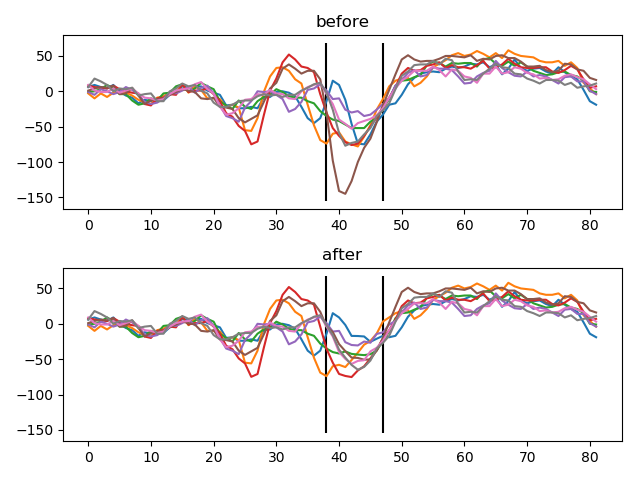

In [34]:
#window = event_window[center_channel]
new_window = event_window.copy().astype(np.float64)

for i, window in enumerate(event_window):        
    wl, wr = find_left_right(window, None)

    exes = np.hstack((np.arange(wl), np.arange(wr, window.size)))
    whys = window[exes]
    g = scipy.interpolate.interp1d(exes, whys, "cubic")

    new_window[i, :] = g(np.arange(window.size))
    new_window[i, wl:wr] += 3*np.random.randn(wr-wl)

wl, wr = find_left_right(event_window[center_channel])
# exes = np.hstack((np.arange(wl), np.arange(wr, window.size)))
# whys = window[exes]
# g = scipy.interpolate.interp1d(exes, whys, "cubic")
# new_window[center_channel, :] = g(np.arange(window.size))
# new_window[center_channel, wl:wr] += 3*np.random.randn(wr-wl)

ymin = min(event_window.min(), new_window.min()) - 10
ymax = max(event_window.max(), new_window.max()) + 10

plt.figure()
plt.subplot(2,1,1)
plt.plot(event_window.T)
plt.title("before")
plt.vlines((wl, wr), ymin=ymin, ymax=ymax)

plt.subplot(2,1,2)
plt.plot(new_window.T)
plt.title("after")
plt.vlines((wl, wr), ymin=ymin, ymax=ymax)


plt.tight_layout()

In [9]:
# window = event_window[center_channel]
# wl, wr = find_left_right(window)

# exes = np.hstack((np.arange(wl), np.arange(wr, window.size)))
# whys = event_window[:, exes]
# g = scipy.interpolate.interp1d(exes, whys, "cubic")

# new_window = g(np.arange(window.size))
# new_window[:, wl:wr] += 3*np.random.randn(new_window.shape[0], wr-wl)

# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(event_window.T)
# plt.title("before")
# plt.vlines((wl, wr), ymin=window.min(), ymax=window.max())

# plt.subplot(2,1,2)
# plt.plot(new_window.T)
# plt.title("after")
# plt.vlines((wl, wr), ymin=window.min(), ymax=window.max())


# plt.tight_layout()

<IPython.core.display.Javascript object>


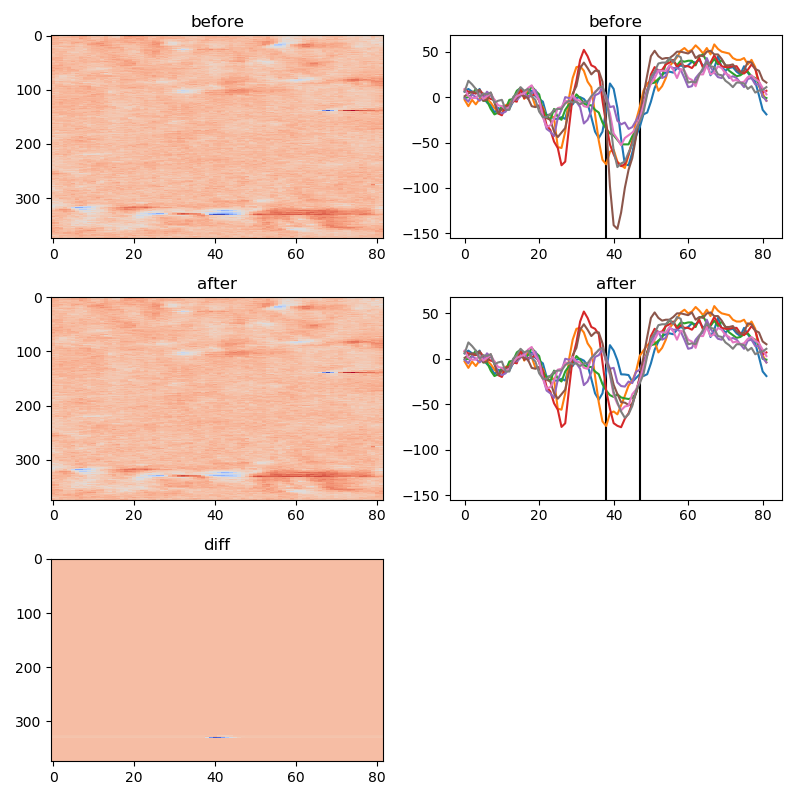

In [35]:
X2 = X.copy()
X2[unit_channels,:] = new_window

X3 = X.copy()
X3[unit_channels,:] = 0

vmin = max(X.min(), X2.min())
vmax = min(X.max(), X2.max())
ymin = min(event_window.min(), new_window.min()) - 10
ymax = max(event_window.max(), new_window.max()) + 10

plt.figure(figsize=(8, 8))
plt.subplot(3,2,1)
plt.imshow(X[probe.channel_map[probe.connected]], "coolwarm", aspect="auto",
           vmin=vmin, vmax=vmax)
plt.title("before")
#plt.colorbar()

plt.subplot(3,2,2)
plt.plot(event_window.T)
plt.ylim(ymin, ymax)
plt.title("before")
plt.vlines((wl, wr), ymin=ymin, ymax=ymax)

plt.subplot(3,2,3)
plt.imshow(X2[probe.channel_map[probe.connected]], "coolwarm", aspect="auto",
           vmin=vmin, vmax=vmax)
plt.title("after")
#plt.colorbar()

plt.subplot(3,2,4)
plt.plot(new_window.T)
plt.ylim(ymin, ymax)
plt.vlines((wl, wr), ymin=ymin, ymax=ymax)
plt.title("after")

plt.subplot(3,2,5)
plt.imshow((X-X2)[probe.channel_map[probe.connected]], "coolwarm", aspect="auto",
           vmin=vmin, vmax=vmax)
plt.title("diff")

plt.tight_layout()

In [11]:
plt.savefig("fig.png")